In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

import os

In [2]:
class MLP(chainer.Chain):
    def __init__(self,n_units, n_out):
        super(MLP, self).__init__(
        l1 = L.Linear(None, n_units),
        l2 = L.Linear(None, n_units),
        l3 = L.Linear(None, n_out)
        )
    def __call__(self, x):
        t = np.array([1,2,3,4,5,6])
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        #return self.l3(h2)
        return F.softmax_cross_entropy(self.l3(h2),t)

In [3]:
# define class and function
class MultiLayerPerceptron(chainer.Chain):
    """Class of deep neural network(DNN) description
    
    
    Args:
        nodes(list of int):Nodes of network layers
        dropout(float):Dropout ratio
    """
    
    def __init__(self,nodes):
        #superは親ｸﾗｽ呼び出し。
        #この場合は、親ｸﾗｽであるchainer.Chainの__init__
        #ﾒｿｯﾄﾞを呼び出して使ってる
        super(MultiLayerPerceptron, self).__init__()
        self.nodes = nodes
        self.layers = len(self.nodes)
        for i in range(self.layers-1):
            self.add_link("l{}".format(i),
                          L.Linear(self.nodes[i],
                                   self.nodes[i+1]))
        
    def __call__(self,x):
        """Return predictive values.
        
        Args:
            x([chainer]Variable):Input of DNN
        Returns:
            y([chainer]Variable):Output of DNN
        """
        y = self["l0"](x)
        for i in range(self.layers-2):
            #h = F.relu(y)
            h = F.softmax(y)
            y = self["l{}".format(i+1)](h)
        return y
    
def train_test_tuple_dataset(x,y,test_ratio):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = test_ratio)
    train = chainer.datasets.TupleDataset(x_train, y_train)
    test = chainer.datasets.TupleDataset(x_test, y_test)
    return train,test

#高橋自作
def train_test_tuple_dataset2(x,y,test_data_size):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    #x_train, x_test, y_train, y_test = train_test_split(x,y,
    #                                                    test_size = test_ratio,
    #                                                    random_state=True)
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    i=0
    for i in range(len(x)-test_data_size):
        x_train.append(x[i])
        y_train.append(y[i])
    for i in range(test_data_size):
        x_test.append(x[len(x)-test_data_size+i])
        y_test.append(y[len(y)-test_data_size+i])
   
    train = chainer.datasets.TupleDataset(np.array(x_train), np.array(y_train))
    test = chainer.datasets.TupleDataset(np.array(x_test), np.array(y_test))
    return train,test

def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()

In [4]:
#define csv file
os.chdir("C:\\Users\\Owner\\Desktop\\ML\\6_Data File\\3_boat data")
data_csv_file = "boat_data.csv"

In [5]:
#input columns' name
x_columns = [
    #'1-odds', '2-odds', '3-odds', '4-odds','5-odds','6-odds',
    'Place', '6th-num', '5th-num',
    '4th-num',  '3rd-num', '2nd-num',
    '1st-num', '6th-ratio', '5th-ratio', '4th-ratio',
    '3rd-ratio', '2nd-ratio', '1st-ratio', '6th-ratio2', '5th-ratio2',
    '4th-ratio2', '3rd-ratio2', '2nd-ratio2', '1st-ratio2', '6th-ratioj',
    '5th-ratioj', '4th-ratioj', '3rd-ratioj', '2nd-ratioj', '1st-ratioj',
    '6th-ratioj2', '5th-ratioj2', '4th-ratioj2', '3rd-ratioj2',
    '2nd-ratioj2', '1st-ratioj2', 
    '6th-mratio', '5th-mratio', '4th-mratio',
    '3rd-mratio', '2nd-mratio', '1st-mratio', '6th-bratio', '5th-bratio',
    '4th-bratio', '3rd-bratio', '2nd-bratio', '1st-bratio', 
    '1st-exb','2nd-exb','3rd-exb','4th-exb','5th-exb','6th-exb',
    #'(1, 2, 3)', '(1, 2, 4)', '(1, 2, 5)', '(1, 2, 6)',
    #'(1, 3, 2)', '(1, 3, 4)', '(1, 3, 5)', '(1, 3, 6)', '(1, 4, 2)',
    #'(1, 4, 3)', '(1, 4, 5)', '(1, 4, 6)', '(1, 5, 2)', '(1, 5, 3)',
    #'(1, 5, 4)', '(1, 5, 6)', '(1, 6, 2)', '(1, 6, 3)', '(1, 6, 4)',
    #'(1, 6, 5)', '(2, 1, 3)', '(2, 1, 4)', '(2, 1, 5)', '(2, 1, 6)',
    #'(2, 3, 1)','(2, 3, 4)', '(2, 3, 5)', '(2, 3, 6)', '(2, 4, 1)', '(2, 4, 3)',
    #'(2, 4, 5)', '(2, 4, 6)', '(2, 5, 1)', '(2, 5, 3)', '(2, 5, 4)',
    #'(2, 5, 6)', '(2, 6, 1)', '(2, 6, 3)', '(2, 6, 4)', '(2, 6, 5)',
    #'(3, 1, 2)', '(3, 1, 4)', '(3, 1, 5)', '(3, 1, 6)', '(3, 2, 1)',
    #'(3, 2, 4)', '(3, 2, 5)', '(3, 2, 6)', '(3, 4, 1)', '(3, 4, 2)',
    #'(3, 4, 5)', '(3, 4, 6)', '(3, 5, 1)', '(3, 5, 2)', '(3, 5, 4)',
    #'(3, 5, 6)', '(3, 6, 1)', '(3, 6, 2)', '(3, 6, 4)', '(3, 6, 5)',
    #'(4, 1, 2)', '(4, 1, 3)', '(4, 1, 5)', '(4, 1, 6)', '(4, 2, 1)',
    #'(4, 2, 3)', '(4, 2, 5)', '(4, 2, 6)', '(4, 3, 1)', '(4, 3, 2)',
    #'(4, 3, 5)', '(4, 3, 6)', '(4, 5, 1)', '(4, 5, 2)', '(4, 5, 3)',
    #'(4, 5, 6)', '(4, 6, 1)', '(4, 6, 2)', '(4, 6, 3)', '(4, 6, 5)',
    #'(5, 1, 2)', '(5, 1, 3)', '(5, 1, 4)', '(5, 1, 6)', '(5, 2, 1)',
    #'(5, 2, 3)', '(5, 2, 4)', '(5, 2, 6)', '(5, 3, 1)', '(5, 3, 2)',
    #'(5, 3, 4)', '(5, 3, 6)', '(5, 4, 1)', '(5, 4, 2)', '(5, 4, 3)',
    #'(5, 4, 6)', '(5, 6, 1)', '(5, 6, 2)', '(5, 6, 3)', '(5, 6, 4)',
    #'(6, 1, 2)', '(6, 1, 3)', '(6, 1, 4)', '(6, 1, 5)', '(6, 2, 1)',
    #'(6, 2, 3)', '(6, 2, 4)', '(6, 2, 5)', '(6, 3, 1)', '(6, 3, 2)',
    #'(6, 3, 4)', '(6, 3, 5)', '(6, 4, 1)', '(6, 4, 2)', '(6, 4, 3)',
    #'(6, 4, 5)', '(6, 5, 1)', '(6, 5, 2)', '(6, 5, 3)', '(6, 5, 4)',
    '6th-rank','5th-rank','4th-rank','3rd-rank','2nd-rank','1st-rank'
]




#predict columns' name
y_columns = ['1st']
#network parameters
layer_number = 4
hidden_node_number = 100

#training conditions
io_normalization = True
train_data_number = 40000
epoch_number = 100
batch_size = 100
N_test = 40000
#学習係数等のparameterはAdam内に入ってる
optimizer = chainer.optimizers.Adam()
mylossfun = F.mean_squared_error
myaccfun = F.r2_score

gpu_device = -1 #IF you use gpu, set gpu number(e.g. gpu_device = 0)

#make data set
df = pd.read_csv(data_csv_file, sep=',')

xs = df[x_columns]
ys = df[y_columns]

x_odds1 = df['1-odds']
x_odds2 = df['2-odds']
x_odds3 = df['3-odds']
x_odds4 = df['4-odds']
x_odds5 = df['5-odds']
x_odds6 = df['6-odds']
x_rank1 = df['1st-rank']
x_rank2 = df['2nd-rank']
x_rank3 = df['3rd-rank']
x_rank4 = df['4th-rank']
x_rank5 = df['5th-rank']
x_rank6 = df['6th-rank']

if io_normalization:
    from sklearn.preprocessing import StandardScaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    xs_f = x_scaler.fit_transform(xs).astype(np.float32)
    ys_f = y_scaler.fit_transform(ys).astype(np.float32)
else:
    x_scaler = None
    y_scaler = None
    xs_f = xs.values.astype(np.float32)
    ys_f = ys.values.astype(np.float32)
    #
assert train_data_number < df.shape[0]
test_ratio = 1-train_data_number/df.shape[0]
train, test = train_test_tuple_dataset2(xs_f, ys_f, N_test)
#train, test = train_test_tuple_dataset(xs_f, ys_f, test_ratio)


nodes = [hidden_node_number]*layer_number
nodes[0] = len(x_columns)
nodes[-1] = len(y_columns)

In [6]:
#define multilayer perceptron network
model = L.Classifier(MultiLayerPerceptron(nodes),
                    lossfun = mylossfun,
                    accfun = myaccfun)

#model = L.Classifier(MLP(181,3),lossfun = mylossfun, accfun = myaccfun)

In [7]:
#setup training enviroments
optimizer.setup(model)
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle = False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device = gpu_device)
trainer = chainer.training.Trainer(updater, (epoch_number, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model, device = gpu_device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch',
                                      'iteration',
                                      'elapsed_time',
                                      'main/loss',
                                      'validation/main/loss',
                                      'main/accuracy',
                                      'validation/main/accuracy']))

#exec.training
trainer.run()

if gpu_device >= 0:
    model.to_cpu()

epoch       iteration   elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           468         6.52318       0.998311    0.9487                -8.85231e-05   0.0251081                 
2           936         11.3449       0.946389    0.915266              0.0535572      0.058359                  
3           1404        16.1412       0.926772    0.908376              0.0725289      0.0654206                 
4           1872        21.0563       0.917129    0.905941              0.0807827      0.0682578                 
5           2340        25.8278       0.911834    0.905886              0.0865295      0.0677562                 
6           2808        30.5381       0.90747     0.90608               0.0925855      0.0674914                 
7           3275        34.6827       0.902843    0.906509              0.0951926      0.0670722                 
8           3743        38.3508       0.899095    0.907564              0.099345       0.0

72          33685       291.7         0.745381    1.05844               0.250753       -0.0946936                
73          34153       296.603       0.744522    1.05956               0.251134       -0.0957982                
74          34621       301.739       0.743985    1.06287               0.25309        -0.099326                 
75          35088       306.658       0.741783    1.06421               0.256319       -0.101149                 
76          35556       311.353       0.740565    1.06423               0.256653       -0.10076                  
77          36024       315.47        0.739662    1.06061               0.25646        -0.0964255                
78          36492       319.178       0.738036    1.065                 0.258447       -0.101146                 
79          36960       322.55        0.73713     1.07674               0.257624       -0.114792                 
80          37428       325.7         0.736041    1.06786               0.259972       -

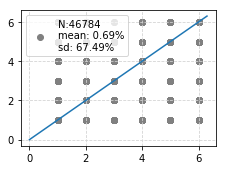

In [8]:
def myplot_aux(model, tuple_dataset, y_scaler = None):
    x = np.array([_x for _x in np.array(tuple_dataset)[:,0]])
    t = np.array([_t for _t in np.array(tuple_dataset)[:,1]])
    
    y = model(x).data
    if y_scaler is not None:
        t = y_scaler.inverse_transform(t)
        y = y_scaler.inverse_transform(y)
        x = x_scaler.inverse_transform(x)
    return t, y, x
model.predictor
t, y, x = myplot_aux(model.predictor, train, y_scaler)
y = np.round(y,0)
myplot(t, y, color = 'gray')
t, y, x = myplot_aux(model.predictor, test, y_scaler)
y = np.round(y,0)
myplot(t, y, color='green')

try:
    y_sch = df[y_columns].values
    p_sch = df[[col + 'sch' for col in y_columns]].values
    myplot(y_sch, p_sch)
except:
    pass

plt.show()

In [9]:
#ｵｯｽﾞ予想読み込み
d = df['1-odds-cls']
odds_cls = []

for i in range(len(t)):
    odds_cls.append(d[len(d)-N_test+i])

In [19]:
balance = 10000
rireki = []
kaisyu = []
odds = []
rank = []
#print(len(x_odds))=86785
        
for i in range(len(t)):
    rank1 = x_rank1[len(x_odds1)-N_test+i]
    rank2 = x_rank2[len(x_odds1)-N_test+i]
    rank3 = x_rank3[len(x_odds1)-N_test+i]
    rank4 = x_rank4[len(x_odds1)-N_test+i]
    rank5 = x_rank5[len(x_odds1)-N_test+i]
    rank6 = x_rank6[len(x_odds1)-N_test+i]
    
    odds.append(x_odds1[len(x_odds1)-N_test+i])
    rank.append(rank1)

    if abs(y[i]-1) < 0.1:
        #if abs(odds_cls[i]-1) < 0.1:
        #if odds[i] > 2:
        #if rank1 >= 3:
            a = balance
            balance = balance -100
            if abs(t[i] - y[i]) < 0.1:
                balance = balance + 100*x_odds1[len(x_odds1)-N_test+i]
            kaisyu.append(balance/a*100)
    rireki.append(balance)

    
plt.plot(rireki)
plt.show()

df_y = pd.DataFrame(y)
df_t = pd.DataFrame(t)
df_r = pd.DataFrame(rireki)
df_odds = pd.DataFrame(odds)
df_rank = pd.DataFrame(rank)


df_M = pd.concat([df_y,df_t,df_r,df_odds,df_rank],axis = 1)
df_M.to_csv("180917_sim.csv")

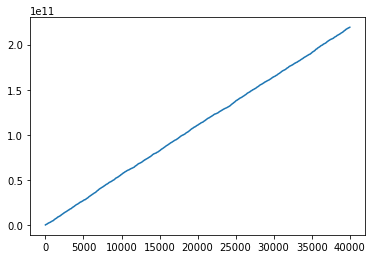

23.1575


In [11]:
####予想トップのオッズが１５倍以上にかける#####
score = 0

cash = 500000
kake = 10000
deposit = []

for i in range(len(t)):
    if abs(t[i][0] - y[i][0]) <= 0.2:
        score = score + 1
    if x[i][int(y[i][0]-1)] > 15:
        cash =cash -kake
        if abs(t[i][0] - y[i][0]) <= 0.2:
            if abs(t[i][0]-1) < 0.1:
                cash = cash + kake*x[i][0]
            elif abs(t[i][0]-2) < 0.1:
                cash = cash + kake*x[i][1]
            elif abs(t[i][0]-3) < 0.1:
                cash = cash + kake*x[i][2]
            elif abs(t[i][0]-4) < 0.1:
                cash = cash + kake*x[i][3]
            elif abs(t[i][0]-5) < 0.1:
                cash = cash + kake*x[i][4]
            elif abs(t[i][0]-6) < 0.1:
                cash = cash + kake*x[i][5]
    deposit.append(cash)
plt.plot(deposit)
plt.show()

print(score/len(t)*100)

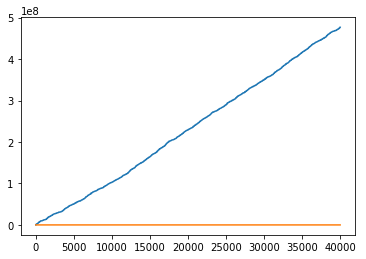

23.1575


In [12]:
####予想トップが１ｺｰｽかつ１ｺｰｽ単勝ｵｯｽﾞが１．５倍以上のみ掛け#####
score = 0

cash = 50000
kake = 10000
deposit2 = []

for i in range(len(t)):
    if abs(t[i][0] - y[i][0]) <= 0.2:
        score = score + 1
    if abs(y[i][0]-1) < 0.1 and x[i][int(y[i][0]-1)] > 2:
        #kake = np.round(cash/5000,0)
        #kake = kake*100
        cash =cash -kake
        if abs(t[i][0] - y[i][0]) <= 0.2:
            if abs(t[i][0]-1) < 0.1:
                cash = cash + kake*(x[i][0]-0.5)
            elif abs(t[i][0]-2) < 0.1:
                cash = cash + kake*(x[i][1]-0.5)
            elif abs(t[i][0]-3) < 0.1:
                cash = cash + kake*(x[i][2]-0.5)
            elif abs(t[i][0]-4) < 0.1:
                cash = cash + kake*(x[i][3]-0.5)
            elif abs(t[i][0]-5) < 0.1:
                cash = cash + kake*(x[i][4]-0.5)
            elif abs(t[i][0]-6) < 0.1:
                cash = cash + kake*(x[i][5]-0.5)
    deposit2.append([cash,kake])
plt.plot(deposit2)
plt.show()

print(score/len(t)*100)

1974212496.17
80.05
55.47470331043098


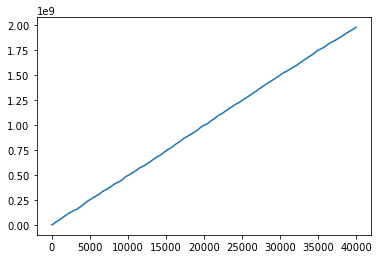

In [13]:
####予想トップが１ｺｰｽかつ１ｺｰｽ単勝ｵｯｽﾞが１．５倍以上のみ掛け#####
a = 0
b=0
cash = 50000
kake = 10000
deposit3= []

for i in range(len(t)):
    if x[i][0] > 5:
        a = a + 1
        cash = cash - kake
        if abs(t[i][0]-1)<0.1:
            cash = cash + kake*(x[i][0]*0.85)
            b = b + 1
    deposit3.append(cash)
print(cash)
print(a/len(t)*100)
print(b/a*100)

plt.plot(deposit3)
plt.show()

In [14]:
x1 =[]
x2 =[]
x3 =[]
x4 =[]
x5 =[]
x6 =[]
for i in range(len(t)):
    x1.append(x[i][0])
    x2.append(x[i][1])
    x3.append(x[i][2])
    x4.append(x[i][3])
    x5.append(x[i][4])
    x6.append(x[i][5])

df_t = pd.DataFrame(t)
df_y = pd.DataFrame(y)
df_1 = pd.DataFrame(x1)
df_2 = pd.DataFrame(x2)
df_3 = pd.DataFrame(x3)
df_4 = pd.DataFrame(x4)
df_5 = pd.DataFrame(x5)
df_6 = pd.DataFrame(x6)
df_d = pd.DataFrame(deposit)
df_d2 = pd.DataFrame(deposit2)
df_d3 = pd.DataFrame(deposit3)

df = pd.concat([df_t,df_y,df_1,df_2,df_3,df_4,df_5,df_6,df_d2,df_d3],axis=1)

df.to_csv("boat_result.csv")